Домашняя работа №1

In [194]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
import xgboost
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

In [20]:
mcc_lib = pd.read_csv('mcc_codes.csv', ';')
mcc_lib.head()

,Код МСС,MCC Группа
0,1,Retail Purchase
1,2,Retail Purchase
2,3,Retail Purchase
3,4,Retail Purchase
4,5,Retail Purchase


In [21]:
mcc_lib.columns = ['MCC', 'MCC_Name']
mcc_lib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1467 entries, 0 to 1466
Data columns (total 2 columns):
MCC         1467 non-null int64
MCC_Name    1467 non-null object
dtypes: int64(1), object(1)
memory usage: 23.0+ KB


In [30]:
mcc_lib = mcc_lib.drop_duplicates(subset='MCC', keep='first')

In [31]:
rosbank_df = pd.read_csv('rosbank_train.csv')
rosbank_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [32]:
rosbank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [33]:
rosbank_df.channel_type.unique()

array([nan, 'type5', 'type4', 'type2', 'type3', 'type1'], dtype=object)

In [34]:
df = rosbank_df[['cl_id', 'MCC', 'channel_type', 'amount', 'trx_category', 'target_flag']]
df.head()

,cl_id,MCC,channel_type,amount,trx_category,target_flag
0,0,5200,NaN,5023.0,POS,0
1,0,6011,NaN,20000.0,DEPOSIT,0
2,0,5921,NaN,767.0,POS,0
3,0,5411,NaN,2031.0,POS,0
4,0,6012,NaN,36562.0,C2C_OUT,0


In [35]:
df_fin = df[['channel_type']].fillna('type6')
df_fin.channel_type.head()

0    type6
1    type6
2    type6
3    type6
4    type6
Name: channel_type, dtype: object

In [36]:
df[['channel_type']] = df_fin[['channel_type']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 6 columns):
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 22.5+ MB


/home/eli/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [37]:
df = pd.merge(df, mcc_lib, on='MCC', how='left')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490513 entries, 0 to 490512
Data columns (total 7 columns):
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
MCC_Name        490040 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 29.9+ MB


In [45]:
df.MCC_Name.value_counts()

Retail Purchase                 182796
Variety/Groc/Food Stores        159776
Restaurant                       73222
Financial Institutions           54382
Unique                            7187
Transportation                    4384
Mail/Telephone/Preauth order      4343
Hotel/Motel                       2760
Jewelry                            846
Vehicle Rental                     221
  Cash                             123
Name: MCC_Name, dtype: int64

In [179]:
df.trx_category.value_counts()

POS               416425
DEPOSIT            21216
WD_ATM_ROS         19104
WD_ATM_PARTNER      9948
C2C_IN              7306
WD_ATM_OTHER        7140
C2C_OUT             5456
BACK_TRX            2687
CAT                 1197
CASH_ADV              34
Name: trx_category, dtype: int64

In [87]:
df.target_flag.value_counts()

1    320103
0    170410
Name: target_flag, dtype: int64

In [116]:
df[['amount', 'target_flag']].describe()

,amount,target_flag
count,4.905130e+05,490513.000000
mean,5.723594e+03,0.652588
std,7.703763e+04,0.476148
min,4.000000e-02,0.000000
25%,2.240000e+02,0.000000
50%,6.240000e+02,1.000000
75%,2.176000e+03,1.000000
max,3.583500e+07,1.000000


In [196]:
corr_matr = df[['amount', 'target_flag']].corr()
corr_matr

,amount,target_flag
amount,1.000000,-0.003336
target_flag,-0.003336,1.000000


In [200]:
grouped_mcc = df[['MCC_Name', 'amount', 'target_flag']].groupby(['MCC_Name', 'target_flag']).agg('count')
viz_mcc = grouped_mcc.unstack(fill_value=0)
viz_mcc

amount        
target_flag                       0       1
MCC_Name                                   
  Cash                           47      76
Financial Institutions        18858   35524
Hotel/Motel                     725    2035
Jewelry                         293     553
Mail/Telephone/Preauth order   1561    2782
Restaurant                    19856   53366
Retail Purchase               64975  117821
Transportation                 1392    2992
Unique                         2852    4335
Variety/Groc/Food Stores      59594  100182
Vehicle Rental                  132      89

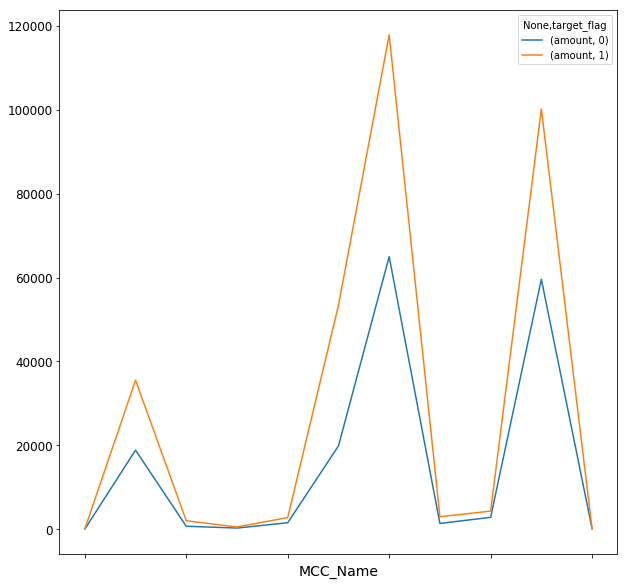

In [210]:
viz_mcc.plot()

In [211]:
grouped_trx = df[['trx_category', 'amount', 'target_flag']].groupby(['trx_category', 'target_flag']).agg('sum')
viz_trx = grouped_trx.unstack(fill_value=0)
viz_trx

amount              
target_flag                0             1
trx_category                              
BACK_TRX        1.095609e+07  1.366308e+07
C2C_IN          4.359287e+07  5.630428e+07
C2C_OUT         3.092606e+07  5.714881e+07
CASH_ADV        5.247632e+05  3.880618e+05
CAT             5.811950e+06  1.679091e+07
DEPOSIT         2.059163e+08  2.768296e+08
POS             3.024480e+08  7.106139e+08
WD_ATM_OTHER    6.468331e+06  6.831229e+07
WD_ATM_PARTNER  1.642713e+08  1.684464e+08
WD_ATM_ROS      2.644598e+08  4.036246e+08

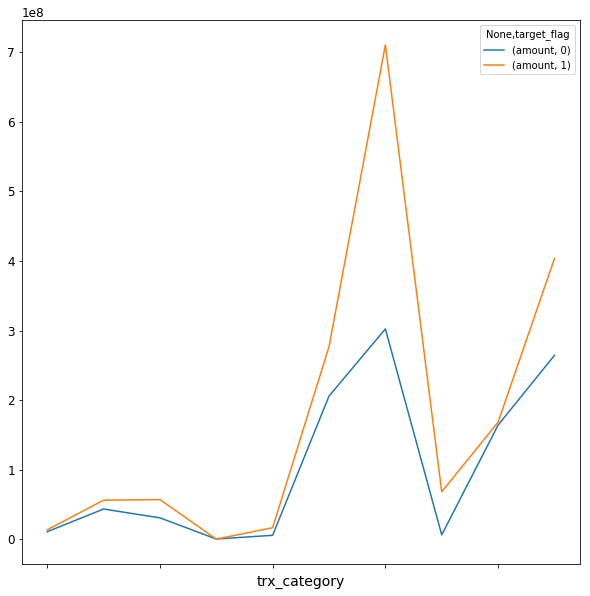

In [212]:
viz_trx.plot()

In [123]:
clients_test = np.random.choice(df.cl_id.unique(), size=1000, replace=False)
clients_test_set = set(clients_test)

In [121]:
df_train = df[~df.cl_id.isin(clients_test)].copy()
print("Total transactions in train dataset: ", len(df_train))
df_test = df[df.cl_id.isin(clients_test)].copy()
print("Total transactions in test dataset: ", len(df_test))

Total transactions in train dataset:  389217
Total transactions in test dataset:  101296


In [140]:
gr_df_tr_mcc = df_train[['cl_id', 'MCC_Name', 'amount']].groupby(['cl_id', 'MCC_Name']).agg(['sum'])
gr_df_tr_ct = df_train[['cl_id', 'channel_type', 'amount']].groupby(['cl_id', 'channel_type']).agg(['sum'])
gr_df_tr_trx = df_train[['cl_id', 'trx_category', 'amount']].groupby(['cl_id', 'trx_category']).agg(['sum'])

In [143]:
df_mcc = gr_df_tr_mcc.unstack(fill_value=0)
df_ct = gr_df_tr_ct.unstack(fill_value=0)
df_trx = gr_df_tr_trx.unstack(fill_value=0)

In [177]:
merged_dfs_buf = pd.merge(df_mcc, df_ct, on='cl_id', how='left')
merged_dfs_buf.shape

(4000, 17)

In [182]:
merged_dfs = pd.merge(merged_dfs_buf, df_trx, on='cl_id', how='left')
merged_dfs.shape

(4000, 27)

In [183]:
df_targets = df[['cl_id', 'target_flag']].drop_duplicates().copy()
df_targets.index = df_targets['cl_id']
df_targets = df_targets.drop('cl_id', axis=1)
df_targets.head()

,target_flag
cl_id,
0,0
1,0
5,1
9,0
10,0


In [189]:
df_fin = pd.merge(merged_dfs, df_targets, left_index=True, right_index=True,how='inner')
df_fin.head()

/home/eli/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(amount, sum, Cash)","(amount, sum, Financial Institutions)","(amount, sum, Hotel/Motel)","(amount, sum, Jewelry)","(amount, sum, Mail/Telephone/Preauth order)","(amount, sum, Restaurant)","(amount, sum, Retail Purchase)","(amount, sum, Transportation)","(amount, sum, Unique)","(amount, sum, Variety/Groc/Food Stores)",...,"(amount, sum, C2C_IN)","(amount, sum, C2C_OUT)","(amount, sum, CASH_ADV)","(amount, sum, CAT)","(amount, sum, DEPOSIT)","(amount, sum, POS)","(amount, sum, WD_ATM_OTHER)","(amount, sum, WD_ATM_PARTNER)","(amount, sum, WD_ATM_ROS)",target_flag
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,20000.0,0.0,0.0,0.0,0.00,42352.00,0.00,0.0,2031.00,...,0.0,36562.00,0.0,0.00,20000.0,7821.00,0.0,0.0,0.0,0
1,0.0,145000.0,0.0,0.0,0.0,85680.28,21775.50,0.00,0.0,15122.26,...,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,0.0,50000.0,0
5,0.0,208000.0,2940.0,3719.0,4800.0,3836.00,207799.08,62418.95,0.0,52856.10,...,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,6000.0,66500.0,1
9,0.0,540000.0,0.0,0.0,0.0,0.00,309276.09,0.00,0.0,39.00,...,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,100000.0,435000.0,0
10,0.0,854000.0,0.0,0.0,0.0,2329.00,140734.38,0.00,21692.9,105587.71,...,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,5400.0,422300.0,0


In [191]:
clf = LogisticRegression()
X_train = df_fin.drop(['target_flag'], axis=1)
y_train = df_fin['target_flag']

In [192]:
clf.fit(X=X_train, y=y_train)

/home/eli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [193]:
y_train_predict = clf.predict_proba(X_train)[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  0.74


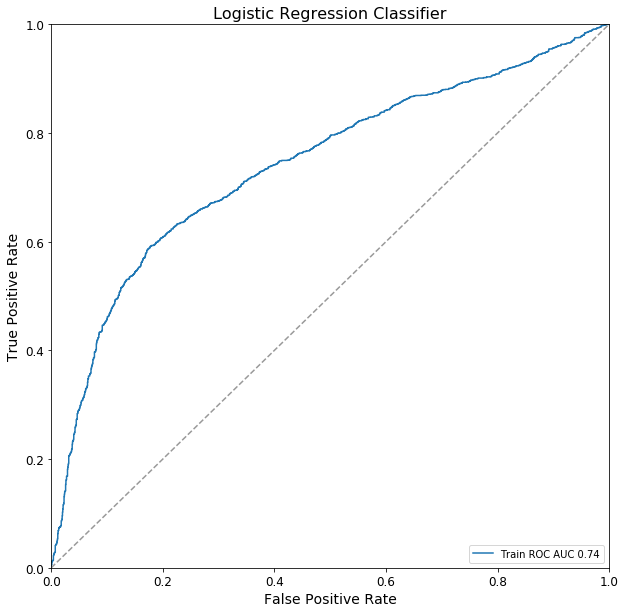

In [195]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Classifier', size=16)
plt.legend(loc='lower right')
plt.show()